## 1. 필요한 라이브러리 다운

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

## 2. 데이터 다운

In [2]:
location = 'data/for_statistic/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.70,50,26.00,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.43,57,15.00,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.91,61,15.00,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.43,61,6.00,12,117,129


## 3. 전처리 함수 (feature_engineering과 non_feature_engineering)

In [3]:
def non_feature_engineering(raw):
    raw_nfe = raw.copy()
    if 'datetime' in raw_nfe.columns:
        raw_nfe['datetime'] = pd.to_datetime(raw_nfe['datetime'])
        raw_nfe['DateTime'] = pd.to_datetime(raw_nfe['datetime'])
    
    if raw_nfe.index.dtype == 'int64':
        raw_nfe.set_index('DateTime', inplace=True)
    # if raw_nfe.index.dtype != 'int64':
    #     raw_nfe.reset_index(drop=False, inplace=True)
    
    raw_nfe = raw_nfe.asfreq('H', method='ffill')
    
    return raw_nfe

In [4]:
def feature_engineering(raw):
    raw_fe = raw.copy()
    if 'datetime' in raw_fe.columns:
        raw_fe['datetime'] = pd.to_datetime(raw_fe['datetime'])
        raw_fe['DateTime'] = pd.to_datetime(raw_fe['datetime'])

    if raw_fe.index.dtype == 'int64':
        raw_fe.set_index('DateTime', inplace=True)

    raw_fe = raw_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw_fe['count'], model='additive')

    y_trend = pd.DataFrame(result.trend)
    y_trend.fillna(method='ffill', inplace=True)
    y_trend.fillna(method='bfill', inplace=True)
    y_trend.columns = ['count_trend']

    y_seasonal = pd.DataFrame(result.seasonal)
    y_seasonal.fillna(method='ffill', inplace=True)
    y_seasonal.fillna(method='bfill', inplace=True)
    y_seasonal.columns = ['count_seasonal']

    null_counts = pd.concat([raw_fe, y_trend, y_seasonal], axis=1).isnull().sum()
    print(null_counts)
    if 'count_trend' not in raw_fe.columns:
        if 'count_seasonal' not in raw_fe.columns:
            raw_fe = pd.concat([raw_fe, y_trend, y_seasonal], axis=1)

    y_count_day = raw_fe[['count']].rolling(24).mean()
    y_count_day.fillna(method='ffill', inplace=True)
    y_count_day.fillna(method='bfill', inplace=True)
    y_count_day.columns = ['count_Day']

    y_count_week = raw_fe[['count']].rolling(24*7).mean()
    y_count_week.fillna(method='ffill', inplace=True)
    y_count_week.fillna(method='bfill', inplace=True)
    y_count_week.columns = ['count_Week']
    
    if 'count_Day' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, y_count_day], axis=1)
    if 'count_Week' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, y_count_week], axis=1)

    y_diff = raw_fe[['count']].diff()
    y_diff.fillna(method='ffill', inplace=True)
    y_diff.fillna(method='bfill', inplace=True)
    y_diff.columns = ['count_diff']

    if 'count_diff' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, y_diff], axis=1)

    raw_fe['temp_group'] = pd.cut(raw_fe['temp'], 10)

    raw_fe['Year'] = raw_fe.datetime.dt.year
    raw_fe['Quater'] = raw_fe.datetime.dt.quarter
    raw_fe['Quater_ver2'] = raw_fe['Quater'] + (raw_fe.Year - raw_fe.Year.min())*4
    raw_fe['Month'] = raw_fe.datetime.dt.month
    raw_fe['Day'] = raw_fe.datetime.dt.day
    raw_fe['Hour'] = raw_fe.datetime.dt.hour
    raw_fe['DayofWeek'] = raw_fe.datetime.dt.dayofweek

    raw_fe['count_lag1'] = raw_fe['count'].shift(1)
    raw_fe['count_lag2'] = raw_fe['count'].shift(2)
    raw_fe['count_lag1'].fillna(method='bfill', inplace=True)
    raw_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw_fe.columns]:
            dummy_vars = pd.get_dummies(raw_fe['Quater'], prefix='Quater_Dummy', drop_first=True)
            dummy_vars = dummy_vars.astype(int)
            raw_fe = pd.concat([raw_fe, dummy_vars], axis=1)
            del raw_fe['Quater']
    return raw_fe

## 4. 데이터 분할함수

In [5]:
def datasplit_cs(raw, y_colname, x_colname, test_size, random_seed=123):
    x_train, x_test, y_train, y_test = train_test_split(raw[x_colname],
                                                        raw[y_colname],
                                                        test_size=test_size,
                                                        random_state=random_seed)
    print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
    print('x_test : ',x_test.shape, 'y_test : ',y_test.shape)
    return x_train, x_test, y_train, y_test

def datasplit_ts(raw, y_colname, x_colname, criteria):
    raw_train = raw.loc[raw.index < criteria, :]
    raw_test = raw.loc[raw.index >= criteria, :]
    y_train = raw_train[y_colname]
    x_train = raw_train[x_colname]
    y_test = raw_test[y_colname]
    x_test = raw_test[x_colname]
    print('Train_size : ',raw_train.shape, 'Test_size : ',raw_test.shape)
    print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
    print('x_test : ',x_test.shape, 'y_test : ',y_test.shape)
    return x_train, x_test, y_train, y_test

## 5. 모델 결괏값 평가

In [6]:
def evaluation(y_real, y_pred, graph_on=False):
    loss_length = len(y_real.values.flatten()) - len(y_pred)
    if loss_length != 0:
        y_real = y_real[loss_length:]
    if graph_on == True:
        pd.concat([y_real, pd.DataFrame(y_pred, index=y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(y_real.index.min(),y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)

    MAE = abs(y_real.values.flatten() - y_pred).mean()
    MSE = ((y_real.values.flatten() - y_pred)**2).mean()
    MAPE = (abs(y_real.values.flatten() - y_pred)/y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE','MSE','MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(y_real.values.flatten() - y_pred, index=y_real.index, columns=['Error'])
    return Score, Residual

def evaluation_trte(y_real_tr, y_pred_tr, y_real_te, y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(y_real_tr, y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(y_real_te, y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train','Test']
    return Score_trte, Residual_tr, Residual_te

## 6. 회귀분석(feature engineering)

In [7]:
raw_fe = feature_engineering(raw_all)
raw_fe

datetime          0
season            0
holiday           0
workingday        0
weather           0
temp              0
atemp             0
humidity          0
windspeed         0
casual            0
registered        0
count             0
count_trend       0
count_seasonal    0
dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,2012-12-19 19:00:00,4,0,1,1,15.58,19.70,50,26.00,7,...,8,12,19,19,2,569.00,562.00,0,0,1
2012-12-19 20:00:00,2012-12-19 20:00:00,4,0,1,1,14.76,17.43,57,15.00,10,...,8,12,19,20,2,336.00,569.00,0,0,1
2012-12-19 21:00:00,2012-12-19 21:00:00,4,0,1,1,13.94,15.91,61,15.00,4,...,8,12,19,21,2,241.00,336.00,0,0,1


In [8]:
y_colname = ['count']
x_remove = ['datetime', 'Datetime', 'temp_group', 'casual', 'registered']
x_colname = [x for x in raw_fe.columns if x not in y_colname+x_remove]
x_train, x_test, y_train, y_test = datasplit_ts(raw_fe, y_colname, x_colname, '2012-07-01')

Train_size :  (13128, 29) Test_size :  (4128, 29)
x_train :  (13128, 24) y_train :  (13128, 1)
x_test :  (4128, 24) y_test :  (4128, 1)


In [9]:
# LinearRegression
fit_reg1 = sm.OLS(y_train, x_train).fit()
display(fit_reg1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.556e+08
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        09:37:18   Log-Likelihood:                 1910.4
No. Observations:               13128   AIC:                            -3775.
Df Residuals:                   13105   BIC:                            -3603.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0090      0.007     -1.350      0.177      -0.022       0.004
holiday            0.0126      0.017      0.762      0.446      -0.020       0.045
workingday         0.0098      0.007      1.375      0.169      -0.004       0.024
weather            0.0062      0.004      1.753      0.080      -0.001       0.013
temp               0.0031      0.002      1.391      0.164      -0.001       0.007
atemp             -0.0032      0.002     -1.651      0.099      -0.007       0.001
humidity          -0.0001      0.000     -0.802      0.423      -0.000       0.000
windspeed          0.0003      0.000      1.236      0.217      -0.000       0.001
count_trend        0.0002   9.32e-05      1.732      0.083   -2.13e-05       0.000
count_seasonal  2.118e-05   2.92e-05      0.725      0.468   -3.61e-05    7.84e-05
count_Day       3.021e-05   8.73e-05      0.346      0.729      -0.000       0.000
count_Week     -8.991e-05   6.23e-05     -1.444      0.149      -0.000    3.21e-05
count_diff         1.0000   3.31e-05   3.02e+04      0.000       1.000       1.000
Year           -2.045e-05   8.15e-06     -2.510      0.012   -3.64e-05   -4.48e-06
Quater_ver2        0.0003      0.002      0.213      0.832      -0.003       0.003
Month              0.0044      0.002      1.838      0.066      -0.000       0.009
Day                0.0009      0.000      2.157      0.031    8.12e-05       0.002
Hour               0.0007      0.000      1.824      0.068   -4.99e-05       0.001
DayofWeek          0.0006      0.002      0.381      0.703      -0.003       0.004
count_lag1         1.0000   3.03e-05    3.3e+04      0.000       1.000       1.000
count_lag2     -2.212e-05   3.18e-05     -0.695      0.487   -8.45e-05    4.03e-05
Quater_Dummy_2     0.0046      0.005      0.897      0.369      -0.005       0.015
Quater_Dummy_3    -0.0006      0.005     -0.106      0.916      -0.011       0.010
Quater_Dummy_4    -0.0042      0.005     -0.923      0.356      -0.013       0.005
==============================================================================
Omnibus:                    54409.943   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93313170696.403
Skew:                        -114.145   Prob(JB):                         0.00
Kurtosis:                   13062.046   Cond. No.                     1.52e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.35e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [10]:
pred_tr_reg1 = fit_reg1.predict(x_train).values
pred_te_reg1 = fit_reg1.predict(x_test).values

       MAE  MSE  MAPE
Train 0.01 0.04  0.06
Test  0.01 0.00  0.02
                     Error
DateTime                  
2011-01-01 00:00:00 -23.94
2011-01-01 01:00:00   0.06
2011-01-01 02:00:00   0.06
2011-01-01 03:00:00   0.06
2011-01-01 04:00:00   0.06
...                    ...
2012-06-30 19:00:00  -0.00
2012-06-30 20:00:00  -0.00
2012-06-30 21:00:00  -0.00
2012-06-30 22:00:00  -0.00
2012-06-30 23:00:00  -0.00

[13128 rows x 1 columns]
                     Error
DateTime                  
2012-07-01 00:00:00   0.05
2012-07-01 01:00:00   0.04
2012-07-01 02:00:00   0.04
2012-07-01 03:00:00   0.04
2012-07-01 04:00:00   0.03
...                    ...
2012-12-19 19:00:00  -0.02
2012-12-19 20:00:00  -0.02
2012-12-19 21:00:00  -0.03
2012-12-19 22:00:00  -0.02
2012-12-19 23:00:00  -0.02

[4128 rows x 1 columns]


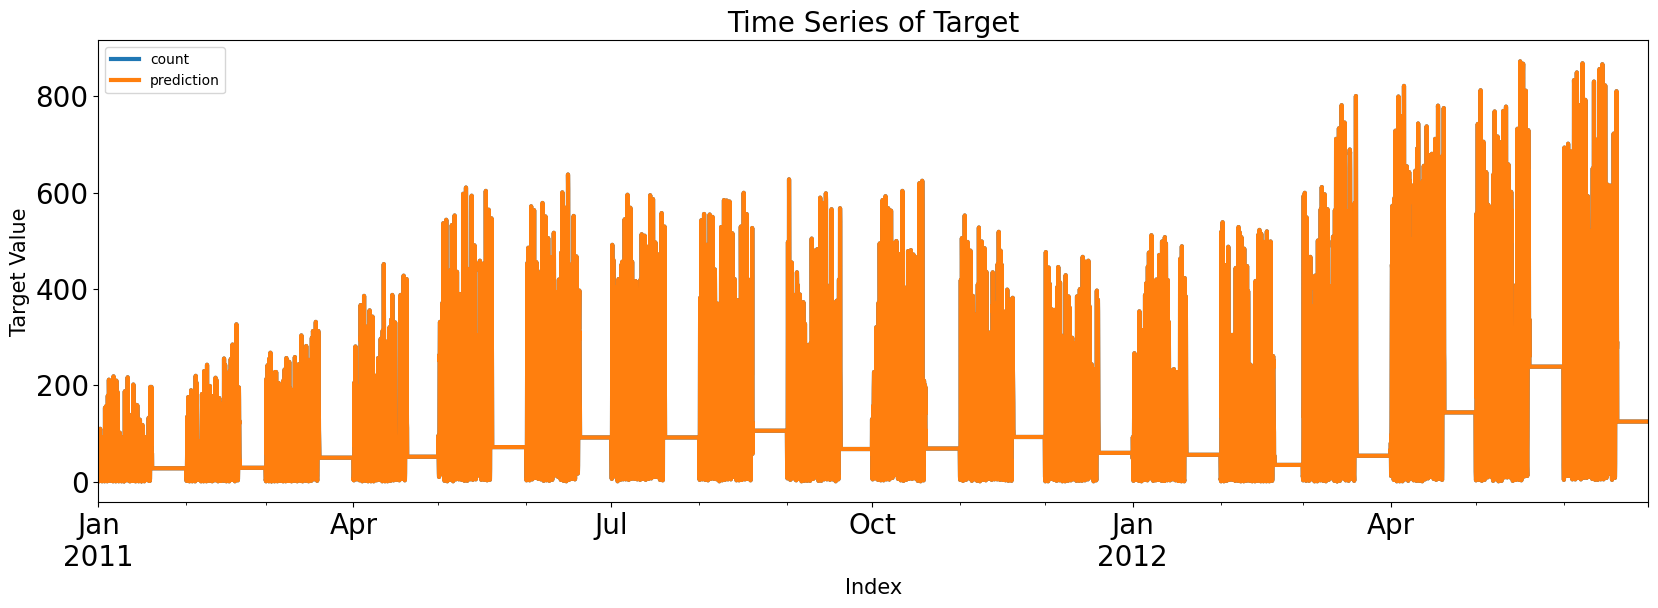

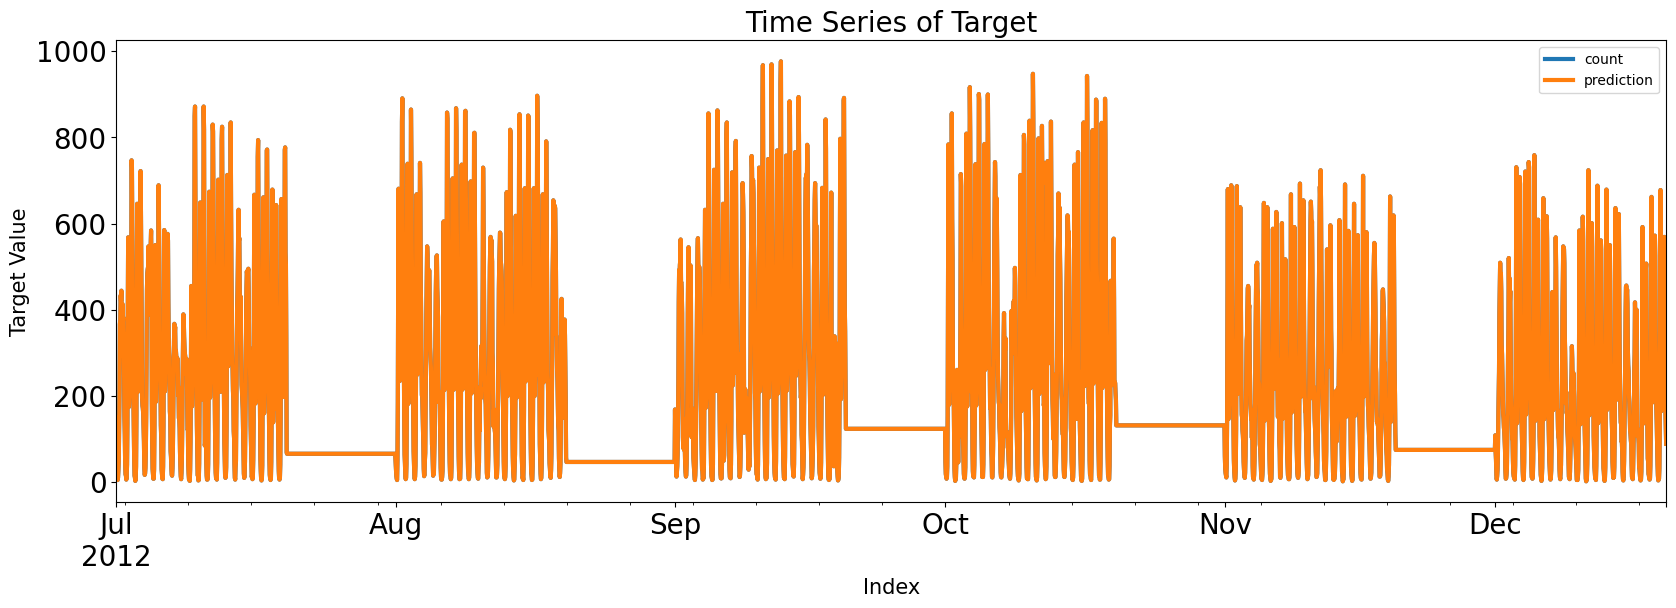

In [11]:
Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(y_train, pred_tr_reg1, y_test, pred_te_reg1, graph_on=True)
print(Score_reg1)
print(Resid_tr_reg1)
print(Resid_te_reg1)

주어진 메모에는 다음과 같은 두 가지 문제가 제기되었습니다:

표준 오류(standard errors)에 대한 가정: 오류의 공분산 행렬이 올바르게 지정되었음을 가정하고 있습니다.
**최소 고유값(eigenvalue)**이 매우 작음: 이는 강한 다중 공선성(multicollinearity) 문제가 있거나 설계 행렬(design matrix)이 특이(singular)함을 나타낼 수 있습니다.
각 문제를 해결하기 위한 방안을 살펴보겠습니다.

[1] 표준 오류에 대한 가정
표준 오류의 가정이 제대로 이루어지지 않았을 때는 다음과 같은 방법을 고려할 수 있습니다:

이분산성(heteroscedasticity) 문제 해결: 이분산성이 존재할 경우, 표준 오류가 잘못 추정될 수 있습니다. 이를 해결하기 위해서는 로버스트 표준 오류(robust standard errors)를 사용할 수 있습니다.

In [ ]:
import statsmodels.api as sm

model = sm.OLS(y, X).fit()
robust_cov = model.get_robustcov_results(cov_type='HC3')  # 'HC0', 'HC1', 'HC2', 'HC3' 등 다양한 옵션이 있습니다.
print(robust_cov.summary())

오류의 자기상관(autocorrelation) 문제 해결: 시계열 데이터에서 발생할 수 있는 자기상관 문제를 해결하기 위해서는 Newey-West 표준 오류를 사용할 수 있습니다.

In [ ]:
newey_west_cov = model.get_robustcov_results(cov_type='HAC', maxlags=1)
print(newey_west_cov.summary())

[2] 최소 고유값이 매우 작음
최소 고유값이 매우 작다는 것은 다중 공선성 문제가 있음을 나타낼 수 있습니다. 이를 해결하기 위한 방법은 다음과 같습니다:

변수 선택 및 제거: 다중 공선성을 유발하는 변수를 제거하거나 선택적으로 사용하는 방법입니다. 분산 팽창 요인(VIF)을 사용하여 다중 공선성을 확인할 수 있습니다.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X는 독립 변수들의 데이터프레임
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


주성분 분석(PCA): 주성분 분석을 통해 변수의 차원을 축소함으로써 다중 공선성을 줄일 수 있습니다.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components='mle')  # MLE 방식으로 최적의 차원 수를 선택
X_pca = pca.fit_transform(X)


릿지 회귀(Ridge Regression): 릿지 회귀는 정규화 항을 추가하여 다중 공선성을 완화합니다.

In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)


특이값 분해(SVD): SVD를 사용하여 설계 행렬의 특이성을 해결할 수 있습니다.

In [ ]:
import numpy as np

U, s, VT = np.linalg.svd(X, full_matrices=False)
s_inv = np.diag(1/s)
X_pseudo_inv = VT.T @ s_inv @ U.T


요약
표준 오류 문제: 이분산성 문제를 로버스트 표준 오류로 해결하거나, 자기상관 문제를 Newey-West 표준 오류로 해결할 수 있습니다.
다중 공선성 문제: VIF를 통해 다중 공선성을 확인하고, 문제가 되는 변수를 제거하거나 릿지 회귀, PCA, SVD와 같은 기법을 통해 문제를 해결할 수 있습니다.
이러한 방법들을 사용하여 모델의 안정성과 신뢰성을 높일 수 있습니다.